<a href="https://colab.research.google.com/github/anandhc6/Assignment-2/blob/main/PartA_Q4%2C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Downloading the dataset as zip folder

!gdown https://storage.googleapis.com/wandb_datasets/nature_12K.zip

Downloading...
From: https://storage.googleapis.com/wandb_datasets/nature_12K.zip
To: /content/nature_12K.zip
100% 3.82G/3.82G [00:15<00:00, 250MB/s]


In [ ]:
# Unzipping the dataset

!unzip -q nature_12K.zip

In [ ]:
#installing wandb

!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 4.9 MB/s 
     |████████████████████████████████| 181 kB 66.3 MB/s 
     |████████████████████████████████| 144 kB 69.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d92be786ee3d6d0c070d3b32b4c1d7797c492708e60ad714728a3e3a80e8af61
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
# import wandb
# wandb.login()
# !wandb login --relogin
# wandb.init(project='A2_partA_Q5',entity="anandh", name = 'Q5a')

In [ ]:
# Importing necessary packages

import pathlib
import numpy as np
from PIL import Image
import os
import glob
import random
from keras.models import load_model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:
# Data preperation

def datagen(batch_size, augment_data):

  Data_dir=pathlib.Path('inaturalist_12K') 
  # augment_data=False
  train_path = os.path.join(Data_dir, "train")
  test_path = os.path.join(Data_dir, "val")

  if augment_data:
    train_rawdata = ImageDataGenerator(rescale=1./255,
                                      rotation_range=90,
                                      zoom_range=0.2,
                                      shear_range=0.2,
                                      validation_split=0.1,
                                      horizontal_flip=True)
    test_rawdata = ImageDataGenerator(rescale=1./255)

  else:
    train_rawdata = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    test_rawdata = ImageDataGenerator(rescale=1./255)

  train_data = train_rawdata.flow_from_directory(
      train_path, 
      target_size=(256, 256), 
      batch_size=batch_size, 
      subset="training",
      color_mode="rgb",
      class_mode='categorical',
      shuffle=True,
      seed=42
      )
  
  val_data = train_rawdata.flow_from_directory(
      train_path, 
      target_size=(256, 256), 
      batch_size=batch_size, 
      subset="validation",
      color_mode="rgb",
      class_mode='categorical',
      #shuffle=True,
      seed=42
      )
  test_data = test_rawdata.flow_from_directory(
      test_path, 
      target_size=(256, 256), 
      batch_size=batch_size,
      color_mode="rgb",
      class_mode='categorical',
      # shuffle=True,
      seed=42
      )
  
  return  train_data, val_data, test_data

In [ ]:
# CNN Model

def CNN_model(activation_func_convolution, activation_func_dense, no_of_filters, filter_convol_size, filter_pool_size, batch_normalisation, dense_layer, dropout,image_size):

  no_of_classes =10
  filter_sizes =[]
  tf.keras.backend.clear_session()

  filter_sizes.append(no_of_filters)
  for layer_num in range(1,3):
      filter_sizes.append(no_of_filters*(2**layer_num))
      filter_sizes.append(no_of_filters*(2**layer_num))
  model = Sequential()
  model.add(Conv2D(filter_sizes[0], kernel_size=(filter_convol_size,filter_convol_size), input_shape=(image_size, image_size, 3), data_format="channels_last"))
  if batch_normalisation:
      model.add(BatchNormalization())
  model.add(Activation(activation_func_convolution[0]))
  model.add(MaxPooling2D(pool_size=filter_pool_size[0] ))

  for i in range(1, 5):
      model.add(Conv2D(filter_sizes[i], kernel_size=(filter_convol_size,filter_convol_size)))
      if batch_normalisation:
          model.add(BatchNormalization())
      model.add(Activation(activation_func_convolution[i]))
      model.add(MaxPooling2D(pool_size=filter_pool_size[i]))
  
  # Converting the feature map into a column vector and regularisation
  model.add(Flatten()) 
  model.add(Dense(dense_layer, activation=activation_func_dense))
  model.add(Dropout(dropout)) 
  model.add(Dense(no_of_classes, activation="softmax")) 

  return model

In [ ]:
#Best model:

# Best parameters
filter_pool_size = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
image_size = 256
activation_func_convolution = ["relu", "relu", "relu", "relu", "relu"]
activation_func_dense = "relu"
no_of_filters = 64
augment_data = True
batch_size = 64
batch_normalisation =True
dropout = 0.15
dense_layer = 128
filter_convol_size = 3


# Data preperation
train_data, val_data, test_data =datagen(batch_size, augment_data)
    
# Model creation
model = CNN_model(activation_func_convolution,activation_func_dense , no_of_filters, filter_convol_size, filter_pool_size, batch_normalisation, dense_layer, dropout ,image_size)
print(model.count_params())

model.compile(optimizer=Adam(learning_rate=0.0001), metrics = ['accuracy'], loss = 'categorical_crossentropy')

train_step_size = train_data.n//train_data.batch_size
print(train_step_size)
val_step_size = val_data.n//val_data.batch_size
print(val_step_size)

model_det = model.fit(train_data,
          steps_per_epoch = train_step_size,
          validation_data = val_data,
          validation_steps = val_step_size,
          epochs=1, 
          #callbacks=[WandbCallback(data_type="image", generator=val_data), earlyStopping, mc],
          verbose=2)
 
#saving the model 
model.save('best_model_1st.h5')




In [ ]:
# Loading the best model

best_model = load_model("best_model_1st.h5")
input_image_shape = (256, 256, 3)

In [ ]:
# Test accuracy

test_predictions = np.argmax(best_model.predict(test_data), axis=-1)
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test accuracy = {test_accuracy*100} %")

32/32 [==============================] - 214s 7s/step - loss: 1.8042 - accuracy: 0.4110
Test accuracy = 41.10000133514404 %


In [ ]:
import wandb
wandb.login()
!wandb login --relogin
wandb.init(project='A2_partA_Q3',entity="anandh", name = 'Q3')

In [ ]:
# Function for plotting filters

def plotGrid(img, row, col):
	plt.figure(figsize=(15, 15))
	plt.subplots_adjust(bottom=0, left=.02, right=.98, top=.80, hspace=.15, wspace=.15)
	for f in range(row * col):
		g=f+1
		plt.subplot(row, col, g)
		k= plt.imshow(img[:,:,f], cmap=plt.cm.gray)
		plt.xticks(())
		plt.yticks(())
	plt.show()
	return k

In [ ]:
#Filters

# load the weights
weights, biases = best_model.layers[0].get_weights()

# add along depth dimension
filters = np.sum(weights, axis = 0)

# normalizing
filter_mini = filters.min()
filter_maxi = filters.max()
filters_numer = (filters - filter_mini) 
filters_denom = (filter_maxi - filter_mini)
filters = filters_numer/filters_denom

filters_al = plotGrid(filters, 8, 8)

first_layer = tf.keras.Model(best_model.inputs, best_model.layers[0].output)
first_layer.summary()



Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Random Image


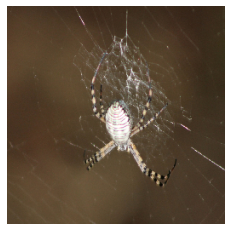

Filters


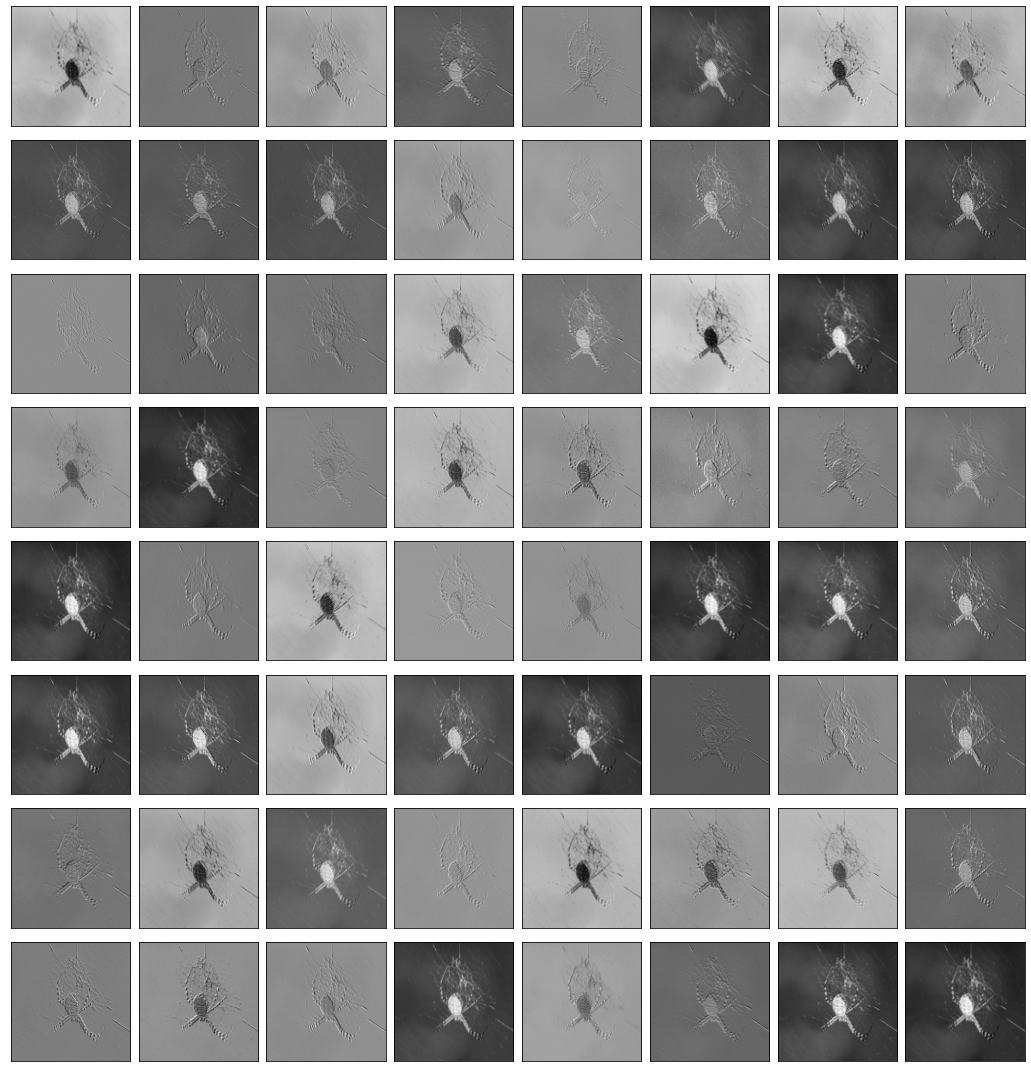

In [ ]:
#filter visualization for a random image

train_data, val_data, test_data =datagen(64, False)

test_data_X, test_data_y = test_data.next()
random_img = test_data_X[random.randint(0, len(test_data_X))]

random_img = np.expand_dims(random_img, axis=0)

random_img_op = first_layer.predict(random_img)

first_layer = tf.keras.Model(best_model.inputs, best_model.layers[0].output)

#Random image
print("Random Image")
plt.axis('off')
fig1=plt.imshow(random_img[0])
plt.show(fig1)

# 64 filters in the first layer
plt.figure(figsize=(15, 15))
filter_grid = 8
iter = 1

for _ in range(filter_grid):
	for _ in range(filter_grid):
		# subplots
		ax = plt.subplot(filter_grid, filter_grid, iter)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel
		fig=plt.imshow(random_img_op[0, :, :, iter-1], cmap='gray')
		iter = iter + 1

print("Filters")
plt.subplots_adjust(wspace=0, hspace=1)
plt.tight_layout()
plt.show(fig)


In [ ]:
wandb.log({"filters_common": wandb.Image(filters_al)})
wandb.log({"filters": wandb.Image(fig)})
wandb.log({"Random_Image": wandb.Image(fig1)})

wandb.finish()